In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# ============================================================================
# 1. CARREGAMENTO E ANÁLISE INICIAL DOS DADOS
# ============================================================================

print("=" * 80)
print("ANÁLISE DE DADOS FALTANTES - DATASET DE IMÓVEIS")
print("=" * 80)

# Carregue seu dataset aqui
df = pd.read_csv('/content/melb_data.csv')


print("\n📊 Primeiras linhas do dataset:")
print(df.head())

print(f"\n📏 Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")

ANÁLISE DE DADOS FALTANTES - DATASET DE IMÓVEIS

📊 Primeiras linhas do dataset:
       Suburb           Address  Rooms Type      Price Method SellerG  \
0  Abbotsford      85 Turner St      2    h  1480000.0      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h  1035000.0      S  Biggin   
2  Abbotsford      5 Charles St      3    h  1465000.0     SP  Biggin   
3  Abbotsford  40 Federation La      3    h   850000.0     PI  Biggin   
4  Abbotsford       55a Park St      4    h  1600000.0     VB  Nelson   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
1  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
2  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   
3  4/03/2017       2.5    3067.0  ...       2.0  1.0      94.0           NaN   
4  4/06/2016       2.5    3067.0  ...       1.0  2.0     120.0         142.0   




IDENTIFICAÇÃO DE DADOS FALTANTES

🔍 Variáveis com dados faltantes:
    Variável  Valores Faltantes  Percentual (%)
BuildingArea               6450       47.496318
   YearBuilt               5375       39.580265
 CouncilArea               1369       10.081001
         Car                 62        0.456554


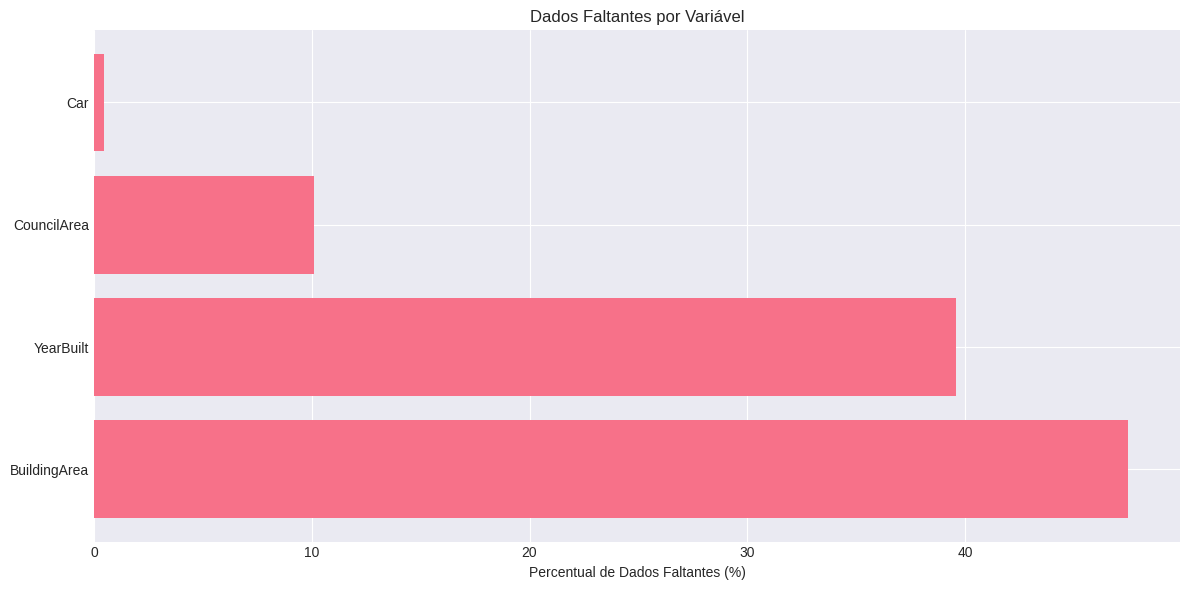

In [3]:
# ============================================================================
# 2. IDENTIFICAÇÃO DE DADOS FALTANTES
# ============================================================================

print("\n" + "=" * 80)
print("IDENTIFICAÇÃO DE DADOS FALTANTES")
print("=" * 80)

# Contagem de valores faltantes
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Variável': missing_counts.index,
    'Valores Faltantes': missing_counts.values,
    'Percentual (%)': missing_percent.values
})

missing_df = missing_df[missing_df['Valores Faltantes'] > 0].sort_values(
    'Valores Faltantes', ascending=False
)

print("\n🔍 Variáveis com dados faltantes:")
print(missing_df.to_string(index=False))

# Visualização dos dados faltantes
plt.figure(figsize=(12, 6))
plt.barh(missing_df['Variável'], missing_df['Percentual (%)'])
plt.xlabel('Percentual de Dados Faltantes (%)')
plt.title('Dados Faltantes por Variável')
plt.tight_layout()
plt.savefig('dados_faltantes_overview.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
# ============================================================================
# 3. SELEÇÃO DE VARIÁVEIS PARA ANÁLISE
# ============================================================================

print("\n" + "=" * 80)
print("SELEÇÃO DE VARIÁVEIS")
print("=" * 80)

# Identifique variáveis numéricas e categóricas com dados faltantes
numeric_missing = []
categorical_missing = []

for col in missing_df['Variável']:
    if df[col].dtype in ['int64', 'float64']:
        numeric_missing.append(col)
    else:
        categorical_missing.append(col)

print(f"\n✅ Variáveis numéricas com dados faltantes: {numeric_missing}")
print(f"✅ Variáveis categóricas com dados faltantes: {categorical_missing}")

# Selecione 2 numéricas e 1 categórica
# Ajuste conforme seu dataset
var_num_1 = numeric_missing[0] if len(numeric_missing) > 0 else 'Price'
var_num_2 = numeric_missing[1] if len(numeric_missing) > 1 else 'Distance'
var_cat_1 = categorical_missing[0] if len(categorical_missing) > 0 else 'Regionname'

print(f"\n🎯 Variáveis selecionadas para análise:")
print(f"   - Numérica 1: {var_num_1}")
print(f"   - Numérica 2: {var_num_2}")
print(f"   - Categórica: {var_cat_1}")


SELEÇÃO DE VARIÁVEIS

✅ Variáveis numéricas com dados faltantes: ['BuildingArea', 'YearBuilt', 'Car']
✅ Variáveis categóricas com dados faltantes: ['CouncilArea']

🎯 Variáveis selecionadas para análise:
   - Numérica 1: BuildingArea
   - Numérica 2: YearBuilt
   - Categórica: CouncilArea


In [5]:
# ============================================================================
# 4. MÉTODOS DE IMPUTAÇÃO
# ============================================================================

def interpolacao_linear(series):
    """Interpolação linear"""
    return series.interpolate(method='linear')

def interpolacao_polinomial(series, order=2):
    """Interpolação polinomial"""
    return series.interpolate(method='polynomial', order=order)

def imputacao_knn(df, column, n_neighbors=5):
    """Imputação usando KNN"""
    imputer = KNNImputer(n_neighbors=n_neighbors)
    # Seleciona apenas colunas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_cols].copy()

    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_numeric),
        columns=numeric_cols,
        index=df_numeric.index
    )
    return df_imputed[column]

def imputacao_simpleimputer(series, strategy='mean'):
    """Imputação usando SimpleImputer"""
    imputer = SimpleImputer(strategy=strategy)
    return pd.Series(
        imputer.fit_transform(series.values.reshape(-1, 1)).flatten(),
        index=series.index
    )


ANÁLISE: BuildingArea (Numérica 1)

📊 Estatísticas originais (sem valores faltantes):
count     7130.000000
mean       151.967650
std        541.014538
min          0.000000
25%         93.000000
50%        126.000000
75%        174.000000
max      44515.000000
Name: BuildingArea, dtype: float64

📈 Comparação entre métodos:
                              Média    Mediana  Desvio Padrão           Min  \
Original (sem NaN)       151.967650  126.00000     541.014538      0.000000   
Interpolação Linear      150.136802  130.00000     395.587138      0.000000   
Interpolação Polinomial  149.567591  128.00000     417.544669 -11184.146397   
KNN (k=5)                149.467361  131.00000     394.458154      0.000000   
SimpleImputer (Média)    151.967650  151.96765     392.002962      0.000000   
SimpleImputer (Mediana)  139.633972  126.00000     392.217403      0.000000   

                             Max  
Original (sem NaN)       44515.0  
Interpolação Linear      44515.0  
Interpolação P

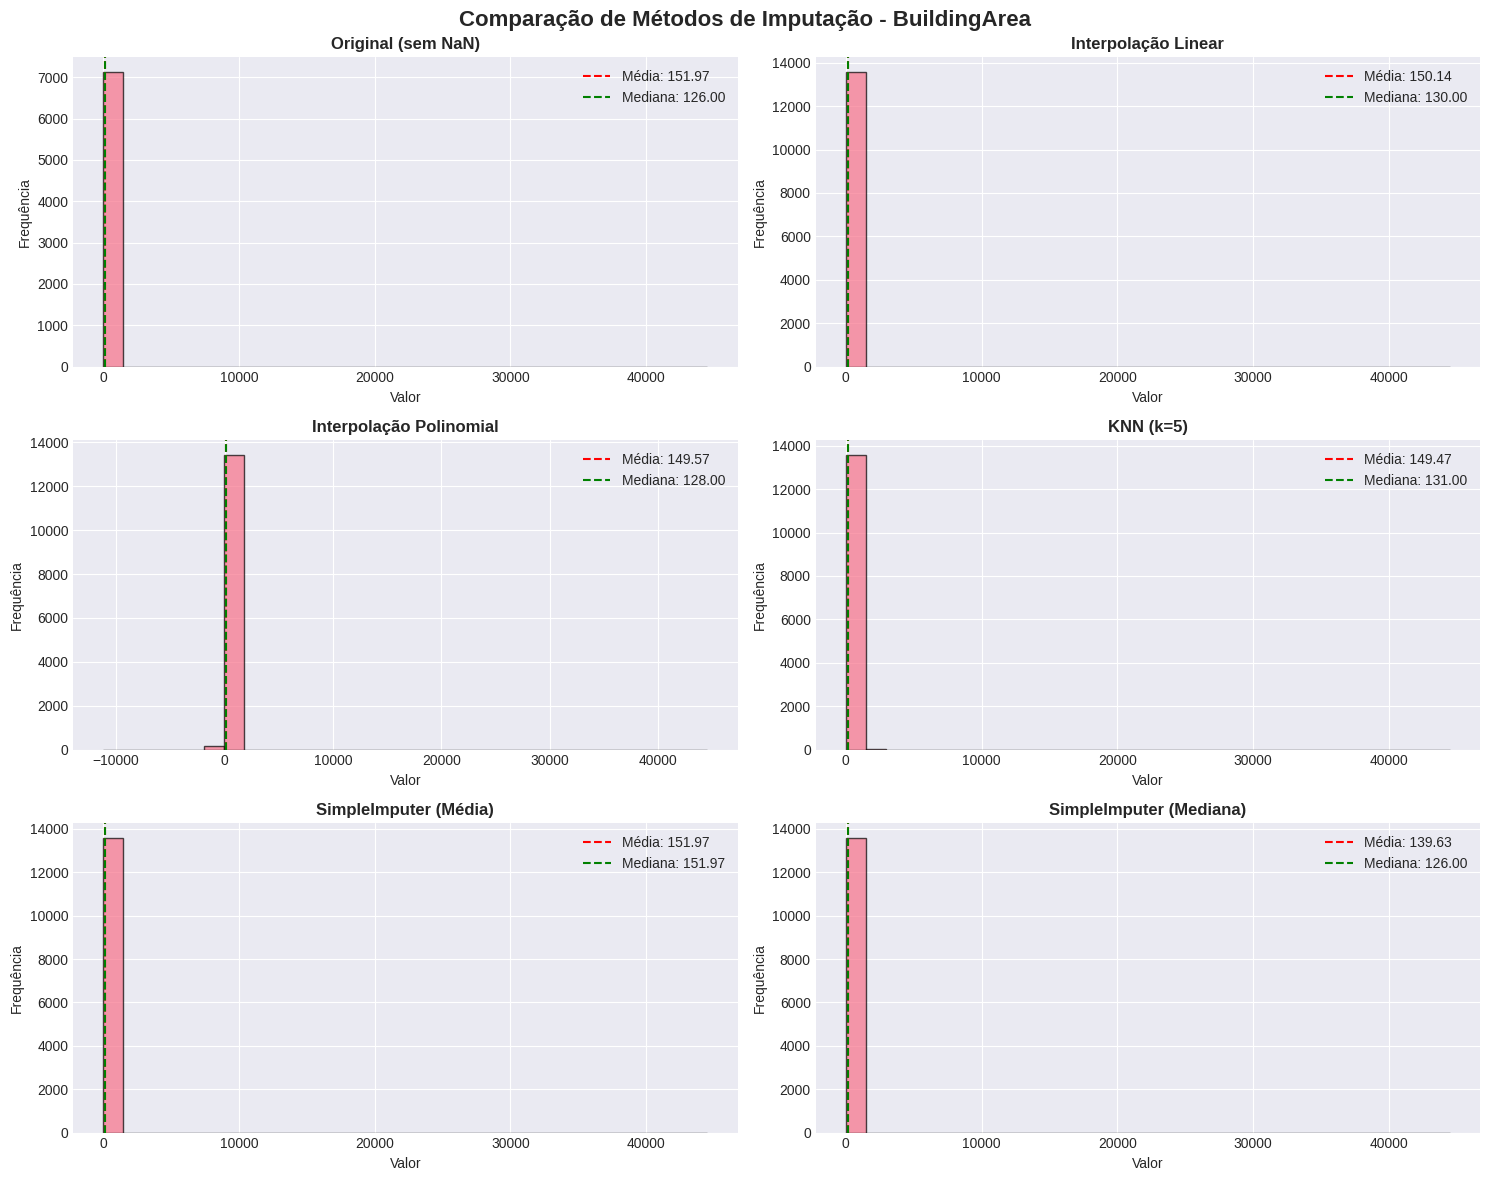

In [6]:
# ============================================================================
# 5. ANÁLISE DA PRIMEIRA VARIÁVEL NUMÉRICA
# ============================================================================

print("\n" + "=" * 80)
print(f"ANÁLISE: {var_num_1} (Numérica 1)")
print("=" * 80)

# Criar cópia dos dados
original_series = df[var_num_1].copy()
print(f"\n📊 Estatísticas originais (sem valores faltantes):")
print(original_series.dropna().describe())

# Aplicar métodos de imputação
methods_results = {}

# 1. Remoção de linhas (baseline)
methods_results['Original (sem NaN)'] = original_series.dropna()

# 2. Interpolação Linear
methods_results['Interpolação Linear'] = interpolacao_linear(original_series)

# 3. Interpolação Polinomial
methods_results['Interpolação Polinomial'] = interpolacao_polinomial(original_series)

# 4. KNN
methods_results['KNN (k=5)'] = imputacao_knn(df, var_num_1)

# 5. SimpleImputer - Média
methods_results['SimpleImputer (Média)'] = imputacao_simpleimputer(original_series, 'mean')

# 6. SimpleImputer - Mediana
methods_results['SimpleImputer (Mediana)'] = imputacao_simpleimputer(original_series, 'median')

# Comparação estatística
print(f"\n📈 Comparação entre métodos:")
comparison_stats = pd.DataFrame({
    method: {
        'Média': data.mean(),
        'Mediana': data.median(),
        'Desvio Padrão': data.std(),
        'Min': data.min(),
        'Max': data.max()
    }
    for method, data in methods_results.items()
}).T

print(comparison_stats)

# Visualização
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f'Comparação de Métodos de Imputação - {var_num_1}', fontsize=16, fontweight='bold')

for idx, (method, data) in enumerate(methods_results.items()):
    row = idx // 2
    col = idx % 2

    axes[row, col].hist(data.dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(method, fontweight='bold')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Frequência')
    axes[row, col].axvline(data.mean(), color='red', linestyle='--',
                           label=f'Média: {data.mean():.2f}')
    axes[row, col].axvline(data.median(), color='green', linestyle='--',
                           label=f'Mediana: {data.median():.2f}')
    axes[row, col].legend()

plt.tight_layout()
plt.savefig(f'imputacao_{var_num_1}.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISE: YearBuilt (Numérica 2)

📊 Estatísticas originais (sem valores faltantes):
count    8205.000000
mean     1964.684217
std        37.273762
min      1196.000000
25%      1940.000000
50%      1970.000000
75%      1999.000000
max      2018.000000
Name: YearBuilt, dtype: float64

📈 Comparação entre métodos:
                               Média      Mediana  Desvio Padrão       Min  \
Original (sem NaN)       1964.684217  1970.000000      37.273762  1196.000   
Interpolação Linear      1964.716511  1970.000000      34.493947  1196.000   
Interpolação Polinomial  1964.728947  1970.000000      43.239233   787.552   
KNN (k=5)                1964.087010  1968.000000      31.700480  1196.000   
SimpleImputer (Média)    1964.684217  1964.684217      28.972246  1196.000   
SimpleImputer (Mediana)  1966.788218  1970.000000      29.088642  1196.000   

                                 Max  
Original (sem NaN)       2018.000000  
Interpolação Linear      2018.000000  
Interpolação Polinomial

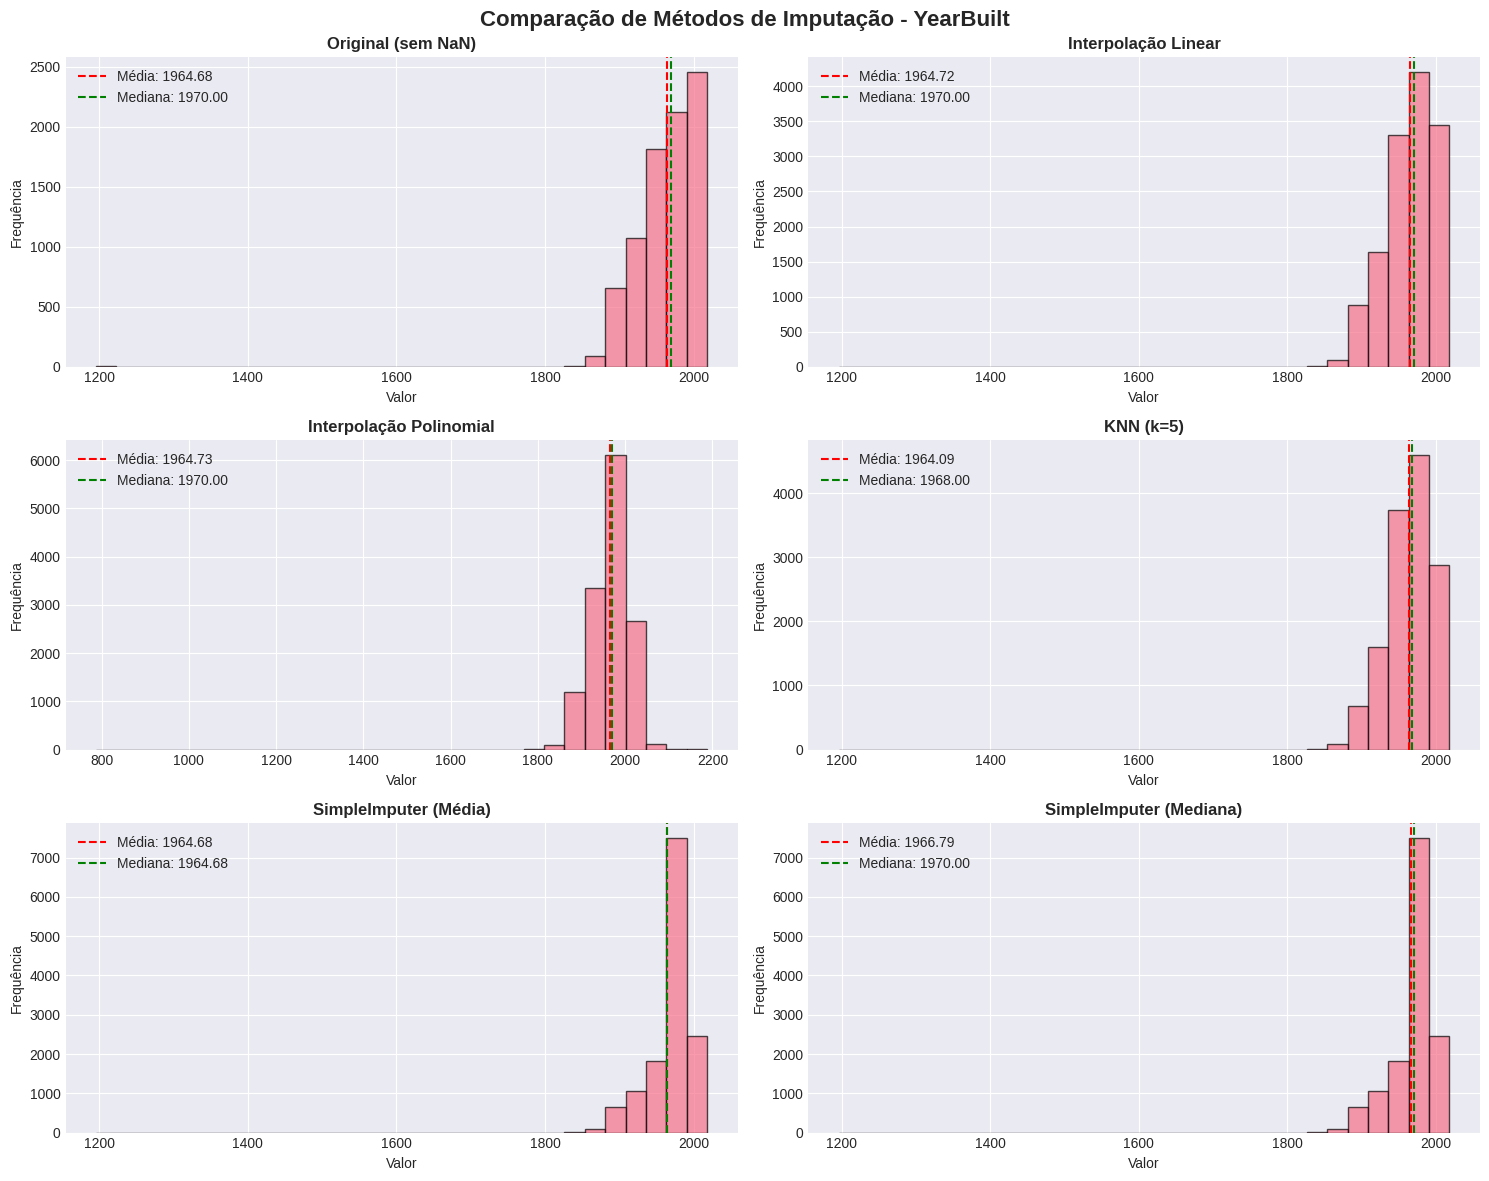

In [7]:
# ============================================================================
# 6. ANÁLISE DA SEGUNDA VARIÁVEL NUMÉRICA
# ============================================================================

print("\n" + "=" * 80)
print(f"ANÁLISE: {var_num_2} (Numérica 2)")
print("=" * 80)

original_series2 = df[var_num_2].copy()
print(f"\n📊 Estatísticas originais (sem valores faltantes):")
print(original_series2.dropna().describe())

methods_results2 = {}
methods_results2['Original (sem NaN)'] = original_series2.dropna()
methods_results2['Interpolação Linear'] = interpolacao_linear(original_series2)
methods_results2['Interpolação Polinomial'] = interpolacao_polinomial(original_series2)
methods_results2['KNN (k=5)'] = imputacao_knn(df, var_num_2)
methods_results2['SimpleImputer (Média)'] = imputacao_simpleimputer(original_series2, 'mean')
methods_results2['SimpleImputer (Mediana)'] = imputacao_simpleimputer(original_series2, 'median')

comparison_stats2 = pd.DataFrame({
    method: {
        'Média': data.mean(),
        'Mediana': data.median(),
        'Desvio Padrão': data.std(),
        'Min': data.min(),
        'Max': data.max()
    }
    for method, data in methods_results2.items()
}).T

print(f"\n📈 Comparação entre métodos:")
print(comparison_stats2)

# Visualização
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle(f'Comparação de Métodos de Imputação - {var_num_2}', fontsize=16, fontweight='bold')

for idx, (method, data) in enumerate(methods_results2.items()):
    row = idx // 2
    col = idx % 2

    axes[row, col].hist(data.dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(method, fontweight='bold')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Frequência')
    axes[row, col].axvline(data.mean(), color='red', linestyle='--',
                           label=f'Média: {data.mean():.2f}')
    axes[row, col].axvline(data.median(), color='green', linestyle='--',
                           label=f'Mediana: {data.median():.2f}')
    axes[row, col].legend()

plt.tight_layout()
plt.savefig(f'imputacao_{var_num_2}.png', dpi=300, bbox_inches='tight')
plt.show()


ANÁLISE: CouncilArea (Categórica)

📊 Distribuição original (sem valores faltantes):
CouncilArea
Moreland         1163
Boroondara       1160
Moonee Valley     997
Darebin           934
Glen Eira         848
Stonnington       719
Maribyrnong       692
Yarra             647
Port Phillip      628
Banyule           594
Name: count, dtype: int64


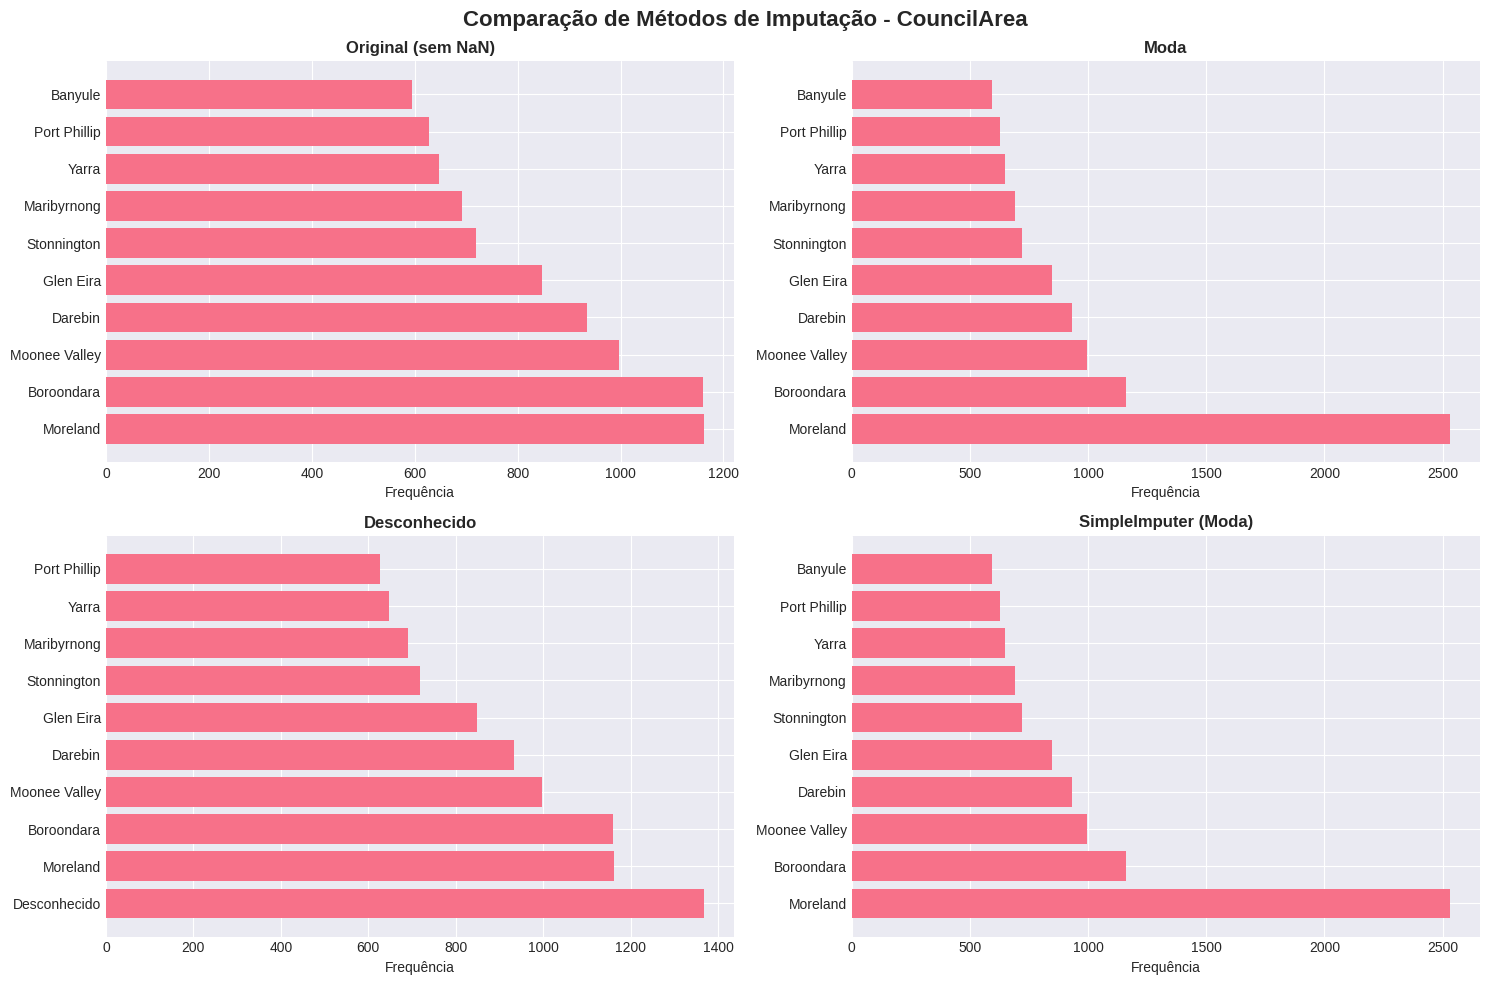

In [8]:
# ============================================================================
# 7. ANÁLISE DA VARIÁVEL CATEGÓRICA
# ============================================================================

print("\n" + "=" * 80)
print(f"ANÁLISE: {var_cat_1} (Categórica)")
print("=" * 80)

original_cat = df[var_cat_1].copy()
print(f"\n📊 Distribuição original (sem valores faltantes):")
print(original_cat.value_counts().head(10))

# Métodos para variável categórica
cat_methods = {}

# 1. Original sem NaN
cat_methods['Original (sem NaN)'] = original_cat.dropna()

# 2. Moda (mais frequente)
cat_methods['Moda'] = original_cat.fillna(original_cat.mode()[0])

# 3. Categoria "Desconhecido"
cat_methods['Desconhecido'] = original_cat.fillna('Desconhecido')

# 4. SimpleImputer (most_frequent)
imputer_cat = SimpleImputer(strategy='most_frequent')
cat_methods['SimpleImputer (Moda)'] = pd.Series(
    imputer_cat.fit_transform(original_cat.values.reshape(-1, 1)).flatten(),
    index=original_cat.index
)

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Comparação de Métodos de Imputação - {var_cat_1}', fontsize=16, fontweight='bold')

for idx, (method, data) in enumerate(cat_methods.items()):
    row = idx // 2
    col = idx % 2

    value_counts = data.value_counts().head(10)
    axes[row, col].barh(range(len(value_counts)), value_counts.values)
    axes[row, col].set_yticks(range(len(value_counts)))
    axes[row, col].set_yticklabels(value_counts.index)
    axes[row, col].set_title(method, fontweight='bold')
    axes[row, col].set_xlabel('Frequência')

plt.tight_layout()
plt.savefig(f'imputacao_{var_cat_1}.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparação dos Métodos de Imputação e Justificativa Final

Nesta etapa, faço uma comparação entre os principais métodos utilizados para tratar os dados faltantes, destacando suas vantagens, limitações e em quais situações cada um funciona melhor. O objetivo é justificar qual método faz mais sentido para o nosso conjunto de dados.

---

## 1. Interpolação Linear

A interpolação linear funciona ligando os valores conhecidos ao redor do dado faltante e preenchendo o meio como se fosse uma reta.

### Vantagens:
- É muito simples e rápida de aplicar
- Mantém a tendência linear dos dados, caso ela exista

### Desvantagens:
- Pressupõe que a relação entre os valores é linear, o que nem sempre é verdade
- Pode não funcionar bem quando existem outliers ou variações bruscas

---

## 2. Interpolação Polinomial

Nesse método, usamos funções polinomiais para tentar capturar relações mais complexas entre os valores.

### Vantagens:
- Consegue modelar comportamentos não-lineares, sendo mais flexível
- Funciona melhor quando os dados têm curvas claras ou comportamentos progressivos

### Desvantagens:
- Pode gerar overfitting, principalmente com polinômios de grau alto
- É menos robusta a outliers

---

## 3. KNN (k-Nearest Neighbors)

O KNN preenche valores faltantes buscando registros semelhantes (vizinhos mais próximos) e estimando novos valores com base nesses vizinhos.

### Vantagens:
- Não assume nenhuma distribuição específica dos dados
- Utiliza a similaridade entre observações, o que pode gerar preenchimentos mais realistas

### Desvantagens:
- Custo computacional mais alto, principalmente em bases grandes
- Sensível à escala das variáveis, exigindo normalização

---

## 4. SimpleImputer — Média

Substitui os valores faltantes pela média da variável.

### Vantagens:
- Extremamente simples e rápido
- Mantém a média original do atributo

### Desvantagens:
- Reduz a variabilidade do conjunto de dados
- Não leva em conta relações entre variáveis

---

## 5. SimpleImputer — Mediana

Similar ao método da média, mas utilizando a mediana.

### Vantagens:
- Muito robusto a outliers
- Simples de aplicar e interpretar

### Desvantagens:
- Assim como a média, também reduz a variabilidade natural dos dados
- Não considera relações entre as outras variáveis

---

## Recomendação Final

### Para variáveis numéricas:
- **KNN** é a melhor opção quando as variáveis apresentam relação entre si e o conjunto de dados tem densidade suficiente
- **Mediana** é indicada quando há muitos outliers
- **Interpolação Linear** funciona bem para variáveis ordenadas ou que seguem uma tendência clara (ex.: séries temporais)

### Para variáveis categóricas:
- **Moda** (valor mais frequente) mantém a distribuição original e, em geral, é a melhor escolha
- Usar uma categoria como **"Desconhecido"** pode ser interessante quando a ausência da informação por si só carrega algum significado relevante

---

## Pontos Importantes

- Quando a porcentagem de valores faltantes é muito pequena (menos de 5%), praticamente qualquer método funciona bem
- Acima de 30% de missing, é importante avaliar se vale a pena manter a variável
- O melhor método depende do tipo de análise que será feita depois, da presença de outliers e da força da correlação entre as variáveis